In [1]:
from brian2 import *
import matplotlib.pyplot as plt

<img src="equations_article.png" width="450px" height="300px">
<img src="equations2_article.png" width="450px" height="300px">

In [2]:
# Zp(x) = (1 / (1 + exp(- bp * (x - op)))) - (1 / (1 + exp(bp * op)))

# Ze(x) = (1 / (1 + exp(- b_e * (x - thet_e)))) - (1 / (1 + exp(b_e * thet_e)))

# Zi(x) = (1 / (1 + exp(- b_i * (x - thet_i)))) - (1 / (1 + exp(b_i * thet_i)))

# Z in the different equations

# Z_e(w1 * E_th) = (1 / (1 + exp(- b_e * ((w1 * E_th) - thet_e)))) - (1 / (1 + exp(b_e * thet_e)))

# Z_e(w2 * E_cx - w3 * I_nrt + w4 * E_dcn - w5 * I_gpi) = (1 / (1 + exp(- b_e * ((w2 * E_cx - w3 * I_nrt + w4 * E_dcn - w5 * I_gpi) - thet_e)))) - (1 / (1 + exp(b_e * thet_e)))

# Z_i(w6 * E_cx) = (1 / (1 + exp(- b_i * ((w6 * E_cx) - thet_i)))) - (1 / (1 + exp(b_i * thet_i)))

# Z_e(ext) = (1 / (1 + exp(- b_e * (ext - thet_e)))) - (1 / (1 + exp(b_e * thet_e)))

# Z_i(w7 * E_stn - w8 * I_gpe) = (1 / (1 + exp(- b_i * ((w7 * E_stn - w8 * I_gpe) - thet_i)))) - (1 / (1 + exp(b_i * thet_i)))

# Z_i(w9 * E_stn) = (1 / (1 + exp(- b_i * ((w9 * E_stn) - thet_i)))) - (1 / (1 + exp(b_i * thet_i)))

# Z_e(w10 * E_cx - w11 * I_gpe) = (1 / (1 + exp(- b_e * ((w10 * E_cx - w11 * I_gpe) - thet_e)))) - (1 / (1 + exp(b_e * thet_e)))

# Equations non-expand
# eqs_ne = Equations(
#     """
# dE_cx/dt = (- E_cx + (k_e - E_cx) * Z_e(w1 * E_th)) / tau_cx : 1
# dE_th/dt = (- E_th + (k_e - E_th) * Z_e(w2 * E_cx - w3 * I_nrt + w4 * E_dcn - w5 * I_gpi)) / tau_th : 1
# dI_nrt/dt = (- I_nrt + (k_i - I_nrt) * Z_i(w6 * E_cx)) / tau_nrt : 1
# dE_dcn/dt = (- E_dcn + (k_e - E_dcn) * Z_e(ext)) / tau_dcn : 1
# dI_gpe/dt = (- I_gpe + (k_i - I_gpe) * Z_i(w7 * E_stn - w8 * I_gpe)) / tau_gpe : 1
# dI_gpi/dt = (- I_gpi + (k_i - I_gpi) * Z_i(w9 * E_stn)) / tau_gpi : 1
# dE_stn/dt = (- E_stn + (k_e - E_stn) * Z_e(w10 * E_cx - w11 * I_gpe)) / tau_stn : 1
# """
# )

# Equations
eqs = Equations(
    """
dE_cx/dt = (- E_cx + (k_e - E_cx) * (1 / (1 + exp(- b_e * ((w1 * E_th) - thet_e)))) - (1 / (1 + exp(b_e * thet_e)))) / tau_cx : 1
dE_th/dt = (- E_th + (k_e - E_th) * (1 / (1 + exp(- b_e * ((w2 * E_cx - w3 * I_nrt + w4 * E_dcn - w5 * I_gpi) - thet_e)))) - (1 / (1 + exp(b_e * thet_e)))) / tau_th : 1
dI_nrt/dt = (- I_nrt + (k_i - I_nrt) * (1 / (1 + exp(- b_i * ((w6 * E_cx) - thet_i)))) - (1 / (1 + exp(b_i * thet_i)))) / tau_nrt : 1
dE_dcn/dt = (- E_dcn + (k_e - E_dcn) * (1 / (1 + exp(- b_e * (ext - thet_e)))) - (1 / (1 + exp(b_e * thet_e)))) / tau_dcn : 1
dI_gpe/dt = (- I_gpe + (k_i - I_gpe) * (1 / (1 + exp(- b_i * ((w7 * E_stn - w8 * I_gpe) - thet_i)))) - (1 / (1 + exp(b_i * thet_i)))) / tau_gpe : 1
dI_gpi/dt = (- I_gpi + (k_i - I_gpi) * (1 / (1 + exp(- b_i * ((w9 * E_stn) - thet_i)))) - (1 / (1 + exp(b_i * thet_i)))) / tau_gpi : 1
dE_stn/dt = (- E_stn + (k_e - E_stn) * (1 / (1 + exp(- b_e * ((w10 * E_cx - w11 * I_gpe) - thet_e)))) - (1 / (1 + exp(b_e * thet_e)))) / tau_stn : 1
"""
)

In [9]:
# Parameters

defaultclock.dt=0.1*ms # for better precision
# k_e = 0.9945
# k_i = 0.9994

# thet_e = 1.3
# b_e = 4

# thet_i = 2.0
# b_i = 3.7


#nouveaux parametres
k_i = 0.9945
k_e = 0.9994

b_e = 1.3
thet_e = 4

b_i = 2.0
thet_i = 3.7

# tau doivent etre entre 10 et 20 ms
tau_cx = 10 * ms
tau_th = 10 * ms
tau_nrt = 10 * ms
tau_dcn = 10 * ms
tau_gpe = 10 * ms
tau_gpi = 10 * ms
tau_stn = 10 * ms

# # Healthy state parameters
# w1 = 20
# w2 = 5
# w3 = 8
# w4 = 25
# w5 = 15
# w6 = 5
# w7 = 19
# w8 = 5
# w9 = 15
# w10 = 20
# w11 = 20
# ext = 3.42

# # Tremor band parameters
# w1 = 20
# w2 = 12
# w3 = 8
# w4 = 9
# w5 = 15
# w6 = 5
# w7 = 5
# w8 = 5
# w9 = 15
# w10 = 20
# w11 = 20
# ext = 3.42

# Beta band parameters
w1 = 20
w2 = 5
w3 = 8
w4 = 20
w5 = 15
w6 = 5
w7 = 5
w8 = 5
w9 = 15
w10 = 20
w11 = 20
ext = 3.42


In [10]:
N = 1
P = NeuronGroup(N, model=eqs, method='euler')

# Initialisation
P.E_cx=0
P.E_th=0
P.I_nrt=0
P.E_dcn=0
P.I_gpe=0
P.I_gpi=0
P.E_stn=0

# # Connexions
# C = Synapses(P, P)
# C.connect(condition="i!=j")

# Enregistrement des traces des groupes de neurones
variables = ["E_cx", "E_th", "I_nrt", "E_dcn", "I_gpe", "I_gpi", "E_stn"]
trace = StateMonitor(P, variables, record=True)
run(1000 * ms, report="text")

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in < 1s


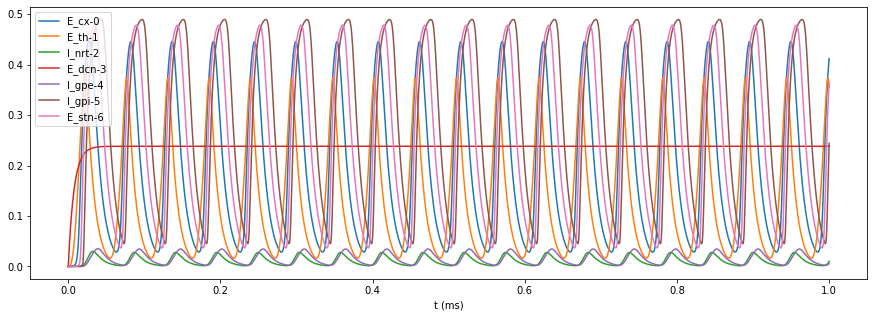

In [11]:
fig,ax=plt.subplots(figsize=(15,5))
for i in range(N):
    traces=[trace.E_cx[i], trace.E_th[i], trace.I_nrt[i], trace.E_dcn[i], trace.I_gpe[i], trace.I_gpi[i], trace.E_stn[i]]
    for i,name in enumerate(variables):
        ax.plot(trace.t, traces[i], label=f"{name}-{i}")
        ax.legend()
    
xlabel("t (ms)")

show()